<a href="https://colab.research.google.com/github/ithabi/AAA/blob/main/AAAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJET AAA : PREDICTION DU SUCCÈS D'UN FILM

Fait avec Google Colab : https://colab.research.google.com/drive/1S9Z8ZcMf_GECJlyPaH_j6ng17Giuw1Vb?usp=sharing

# Notre projet et objectif :

Nous avons décidé d'étudier The Movies Dataset , qui réunit des données sur plus de 40 000 films, et notamment plusieurs milions de notes de spectateurs. Notre but est de créer un modèle pertinent de prédiction la note moyenne des films.

(https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)


# Chargement des données et data exploration
Pour ouvrir le dataset sur google colab, il faut avoir un compte kaggle et éxécuter les 2 cellules ci dessous

In [ ]:
#command lines pour google colab
!pip install -q kaggle
!pip install -q opendatasets

In [ ]:
# TOUS LES IMPORTS DU PROJET

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configuration
from sklearn import set_config
set_config(display="diagram")
%matplotlib inline

In [ ]:
#il faut avoir un compte kaggle !

opendatasets.download(
    "https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: victory1919
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


100%|██████████| 228M/228M [00:00<00:00, 651MB/s]


In [ ]:

movies = pd.read_csv('the-movies-dataset/movies_metadata.csv', low_memory=False)
# low_memory=False permet d'éviter des warnings sur les types mixtes
credits = pd.read_csv('the-movies-dataset/credits.csv')
keywords = pd.read_csv('the-movies-dataset/keywords.csv')
ratings = pd.read_csv('the-movies-dataset/ratings.csv')
links = pd.read_csv('the-movies-dataset/links.csv')

Maintenant que le dataset est chargé, explorons les fichiers qui nous intéressent pour le moment : movies qui contient les films, ratings contient les avis et links permet de faire la jointure entre les 2 fichiers

In [ ]:
def clean_id_column(dataframe, col_name):
    dataframe[col_name] = pd.to_numeric(dataframe[col_name], errors='coerce')
    dataframe.dropna(subset=[col_name], inplace=True)
    dataframe[col_name] = dataframe[col_name].astype(int)
    return dataframe

movies = clean_id_column(movies, 'id')
links = clean_id_column(links, 'tmdbId')
links = clean_id_column(links, 'movieId')
credits = clean_id_column(credits, 'id')

#on crée la feature target et joint les tables  grace à links
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.rename(columns={'rating': 'target_rating'}, inplace=True)
df_temp = pd.merge(movies, links, left_on='id', right_on='tmdbId', how='inner')
df_final = pd.merge(df_temp, avg_ratings, on='movieId', how='inner')

print(f"{df_final.shape[0]} films après nettoyage")



df_final['budget'] = pd.to_numeric(df_final['budget'], errors='coerce')
df_final['runtime'] = pd.to_numeric(df_final['runtime'], errors='coerce')
df_final['popularity'] = pd.to_numeric(df_final['popularity'], errors='coerce')
numerical_features = ['budget', 'runtime', 'popularity']

top_languages = df_final['original_language'].value_counts().index[:10] #les langues sont soit dans le top 10 soit autres
df_final['original_language'] = df_final['original_language'].apply(lambda x: x if x in top_languages else 'other')
categorical_features = ['original_language']

44803 films après nettoyage


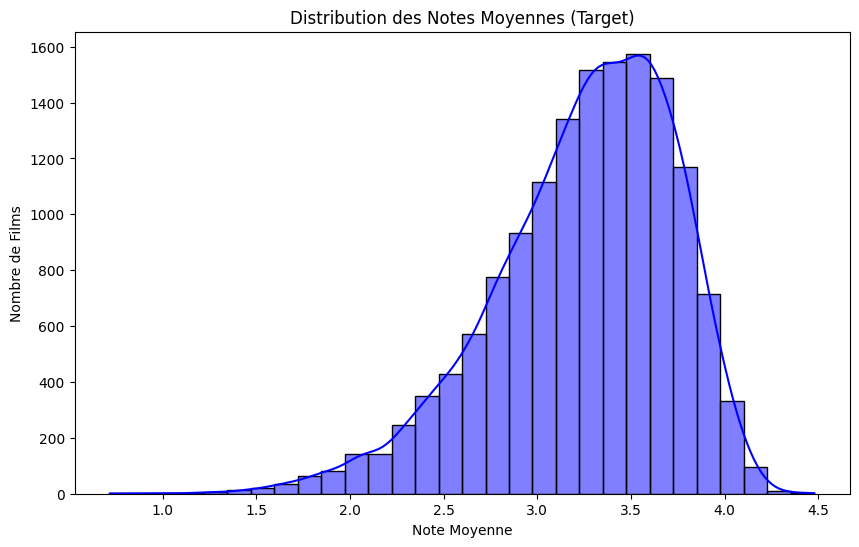

In [ ]:
#ANALYSE DE LA TARGET ET CORRELATIONS

# Distribution de la Target
plt.figure(figsize=(10, 6))
sns.histplot(df_final['target_rating'], kde=True, bins=30, color='blue')
plt.title('Distribution des Notes Moyennes (Target)')
plt.xlabel('Note Moyenne')
plt.ylabel('Nombre de Films')
plt.show()



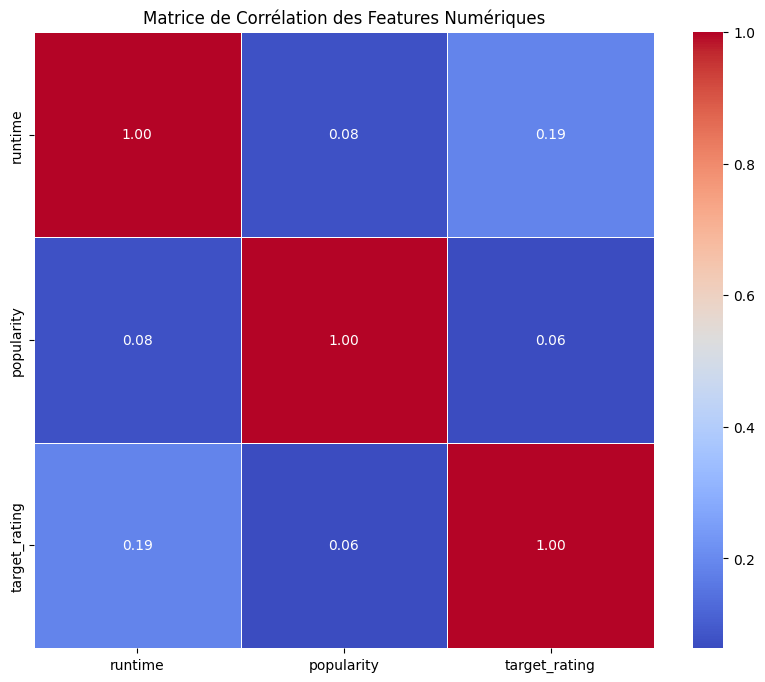

In [ ]:
# 2. Matrice de Corrélation

cols_corr = ['runtime', 'popularity', 'target_rating']

plt.figure(figsize=(10, 8))

corr_matrix = df_final[cols_corr].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation des Features Numériques')
plt.show()

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'release_date'}>,
        <Axes: title={'center': 'revenue'}>],
       [<Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'vote_average'}>,
        <Axes: title={'center': 'vote_count'}>],
       [<Axes: title={'center': 'year'}>, <Axes: >, <Axes: >]],
      dtype=object)

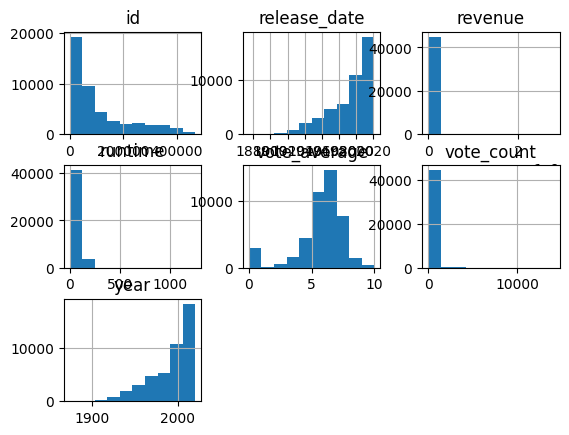

In [ ]:
movies.hist()

On observe que la popularité est faiblement corrélée à la note,
ce qui suggère que les films populaires ne sont pas forcément les mieux notés

# Premier Modèle linéaire

Commençons par un premier modèle linéaire. On va faire d'abord créer la target grâce à '*ratings*' lié à '*movies*' par '*links*'.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features),
     ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)])

model = Pipeline([('preprocessor', preprocessor),('regressor', Ridge(alpha=1.0))])

X = df_final[numerical_features + categorical_features]
y = df_final['target_rating']

# On utilise cross_validate au lieu de cross_val_score pour avoir plusieurs métriques
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(model, X, y, cv=cv, scoring=['neg_root_mean_squared_error', 'r2'])

rmse_scores = -results['test_neg_root_mean_squared_error']
r2_scores = results['test_r2']


print(f"RMSE Moyen : {rmse_scores.mean():.4f} ")
print(f"R² Moyen   : {r2_scores.mean():.4f} ")


RMSE Moyen : 0.7183 
R² Moyen   : 0.0319 


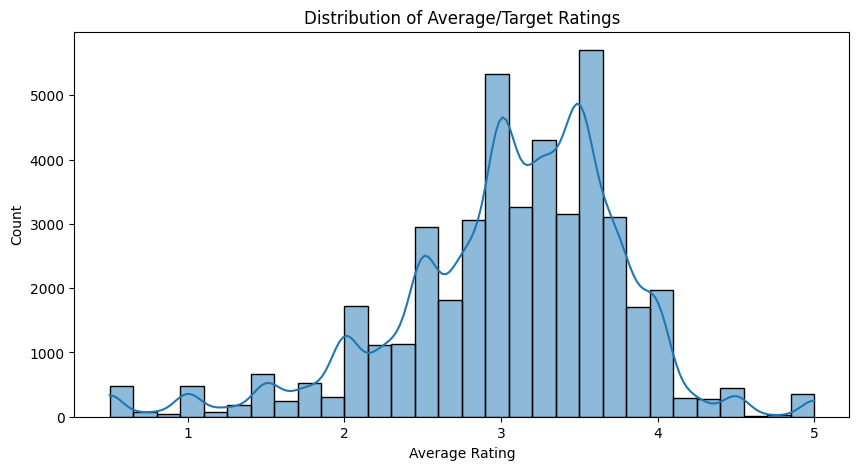

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_final['target_rating'].dropna(), bins=30, kde=True)
plt.title("Distribution of Average/Target Ratings")
plt.xlabel("Average Rating")
plt.show()

In [ ]:
from sklearn import set_config
set_config(display="diagram")
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['budget', 'runtime',
                                                   'popularity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['original_language'])])),
                ('regressor', Ridge())])

# Deuxième modèle linéaire
On constate que nos critères d'évaluation sont insatisfaisants pour le premier modèle (rmse = 0.7 et r²=0.03). Cela peut s'expliquer par notre mauvais choix de features (budget, runtime popularity et original language).

Pour améliorer notre pipeline commencons par changer les features prises en compte : on ajoute 'year', 'director_experience',primary_genre' et 'top_director'. On retire budget car trop de films sont sans budget.

Commençons donc par créer ces features

In [ ]:
def get_primary_genre(x):
    try:
        genres = ast.literal_eval(x)
        if genres:
            return genres[0]['name'] # On prend le premier de la liste
    except:
        pass
    return 'Unknown'

def get_director(x):
    try:
        crew = ast.literal_eval(x)
        for member in crew:
            if member['job'] == 'Director':
                return member['name']
    except:
        pass
    return 'Unknown'
movies['primary_genre'] = movies['genres'].apply(get_primary_genre)
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['year'] = movies['release_date'].dt.year
credits['director'] = credits['crew'].apply(get_director)

movies_with_director = pd.merge(movies, credits[['id', 'director']], on='id', how='inner')
df_temp = pd.merge(movies_with_director, links, left_on='id', right_on='tmdbId', how='inner')


# On ne garde que les films avec > 30 votes
vote_counts = ratings.groupby('movieId').count()['rating']
valid_movies = vote_counts[vote_counts >= 30].index
avg_ratings = ratings[ratings['movieId'].isin(valid_movies)].groupby('movieId')['rating'].mean().reset_index()
avg_ratings.rename(columns={'rating': 'target_rating'}, inplace=True)


df_final = pd.merge(df_temp, avg_ratings, on='movieId', how='inner')
print(f"Dataset Final : {df_final.shape[0]} films")

# Comme pour la langue, on garde le nom si c'est un top 50 réalisateur
director_counts = df_final['director'].value_counts()
df_final['director_experience'] = df_final['director'].map(director_counts)
top_directors = director_counts.head(50).index
df_final['top_director'] = df_final['director'].apply(lambda x: x if x in top_directors else 'Other')

df_final['runtime'] = pd.to_numeric(df_final['runtime'], errors='coerce')
df_final['popularity'] = pd.to_numeric(df_final['popularity'], errors='coerce')



Dataset Final : 14721 films


Analysons les nouvelles features

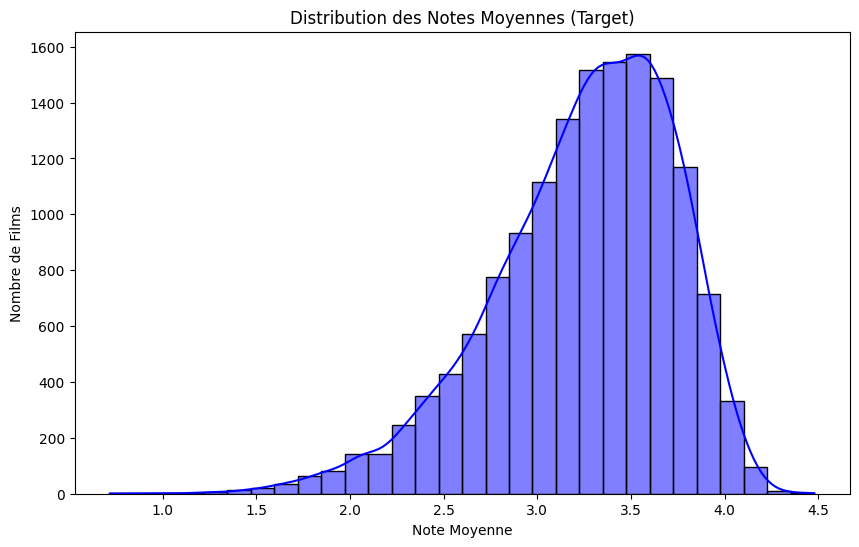

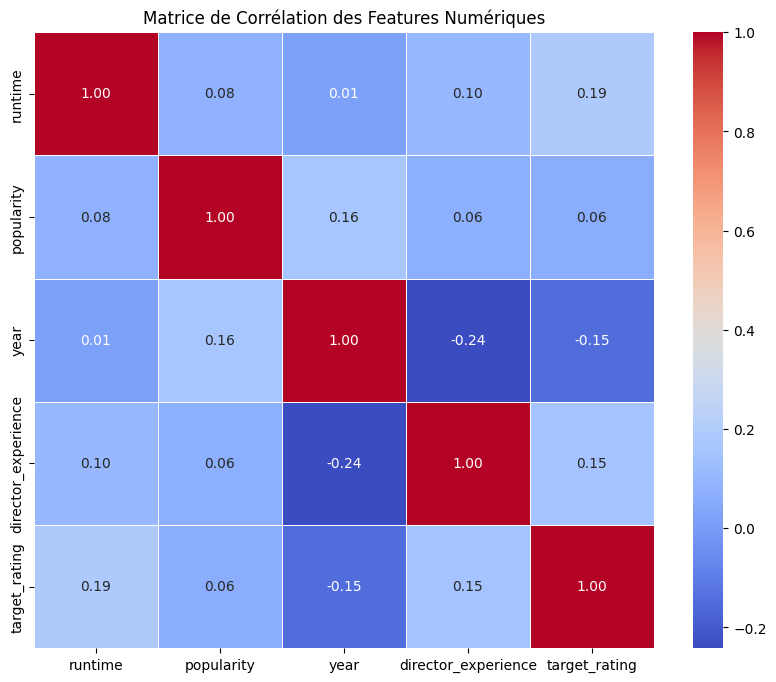

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(df_final['target_rating'], kde=True, bins=30, color='blue')
plt.title('Distribution des Notes Moyennes (Target)')
plt.xlabel('Note Moyenne')
plt.ylabel('Nombre de Films')
plt.show()

#  Matrice de Corrélation

cols_corr = ['runtime', 'popularity', 'year', 'director_experience', 'target_rating']

plt.figure(figsize=(10, 8))

corr_matrix = df_final[cols_corr].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation des Features Numériques')
plt.show()

Poursuivons l'analyse avec du clustering non suupervisé, avec K-means

Moyenne des notes par Cluster :
cluster
0    3.182526
1    3.425030
2    3.746253
Name: target_rating, dtype: float64

Caractéristiques moyennes par Cluster :
            runtime  popularity         year  director_experience
cluster                                                          
0        101.408422    6.414706  2001.976616             4.256847
1        112.590519    5.544430  1970.112708            13.710540
2        129.625000  206.561415  2013.500000             5.562500


/tmp/ipython-input-2945904595.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='target_rating', data=X_cl, palette='Set2')


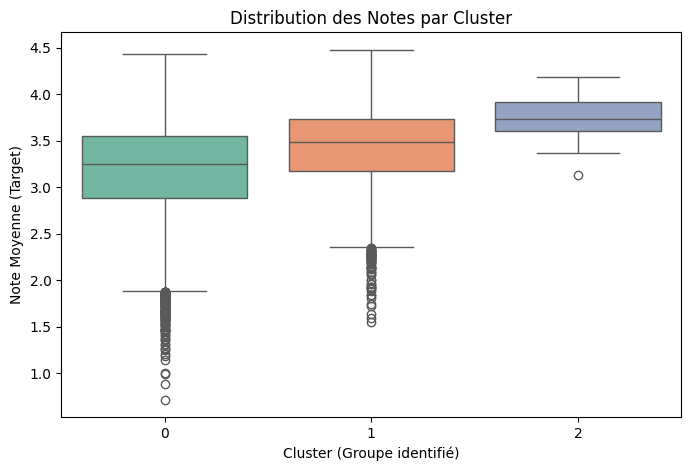

In [ ]:



features_cl = ['runtime', 'popularity', 'year', 'director_experience']
X_cl = df_final[features_cl].dropna().copy()

# Standardisation
scaler_cl = StandardScaler()
X_cl_scaled = scaler_cl.fit_transform(X_cl)

#Application de K-Means

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cl_scaled)


X_cl['cluster'] = clusters
X_cl['target_rating'] = df_final.loc[X_cl.index, 'target_rating']

# Analyse
print("Moyenne des notes par Cluster :")
print(X_cl.groupby('cluster')['target_rating'].mean())

print("\nCaractéristiques moyennes par Cluster :")
print(X_cl.groupby('cluster')[features_cl].mean())

# Visualisation
plt.figure(figsize=(8, 5))
sns.boxplot(x='cluster', y='target_rating', data=X_cl, palette='Set2')
plt.title('Distribution des Notes par Cluster')
plt.xlabel('Cluster (Groupe identifié)')
plt.ylabel('Note Moyenne (Target)')
plt.show()

On peut analyser rapidement les clusters :

2 : des films récents, très longs et populaires, qui obtiennent les meilleures notes du public.

1  : des films plus anciens réalisés par des cinéastes très expérimentés, qui bénéficient également de bonnes critiques.

0 : des films plus courts et peu populaires, qui reçoivent logiquement les notes les plus basses, elle contient le plus de films.

In [ ]:
numeric_features = ['runtime', 'popularity', 'year', 'director_experience']
categorical_features = ['original_language', 'primary_genre', 'top_director']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=100.0))
    #alpha=100 à été choisi gràce à gris search plus loin dans le notebook
])

X = df_final[numeric_features + categorical_features]
y = df_final['target_rating']

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(model, X, y, cv=cv, scoring=['neg_root_mean_squared_error', 'r2'])

rmse_scores = -results['test_neg_root_mean_squared_error']
r2_scores = results['test_r2']

print(f"RMSE Moyen : {rmse_scores.mean():.4f}")
print(f"R² Moyen   : {r2_scores.mean():.4f}")

RMSE Moyen : 0.4237
R² Moyen   : 0.2454


In [ ]:
set_config(display="diagram")
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['runtime', 'popularity',
                                                   'year',
                                                   'director_experience']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['original_language',
                                                   'primary_genre',
                                                   'top_director'])])),
                ('regressor', Ridge(alpha=100.0))])

Les résultats sont beaucoup plus satisfaisants : le rmse est passé d'environ 0.7 à 0.4 tandis que le r² est passé de 0.03 à 0.24, c'est nettement plus satisfaisaisant mais on peut faire mieux encore.

# Grid search pour optimiser un hyperparamètre

Dans notre modèle précédent nous avons introduit arbitaitrement 2 variables :
le nombre d'avis nécessaire pour un film servant au training (30)
le nombre de réalisateur considérés comme top réalisateur (50).

On ne peut faire de **grid search** sur le premier paramètre car il change la taille de la target.(On a donc choisit 30 après plusieurs essais empiriques)


Cependant on peut faire un grid search sur l'autre hyperparamètre, voyons si 50 est la valeur optimale.

**Pour l'instant le grid search n'optimise que alpha**

In [ ]:
param_grid = {"regressor__alpha": (0.1, 1.0, 10.0, 100.0)}
model_grid_search = GridSearchCV(model,param_grid=param_grid,cv=10,scoring='neg_root_mean_squared_error',return_train_score=True)
model_grid_search.fit(X, y)


print(f"Meilleur RMSE : {-model_grid_search.best_score_:.4f}")
print(f"Meilleur alpha : {model_grid_search.best_params_}")
#remarque le resultat semble différent avec un kfold(à approfondir...)
#ajouter ici une optimisation du parametre top 50 realisateur

Meilleur RMSE : 0.4365
Meilleur alpha : {'regressor__alpha': 100.0}


# Troisième modèle : Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

numeric_features = ['runtime', 'popularity', 'year', 'director_experience']
categorical_features = ['original_language', 'primary_genre', 'top_director']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                          ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ])

model_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42))
])

X = df_final[numeric_features + categorical_features]
y = df_final['target_rating']

print("Entraînement de la Random Forest en cours... (cela peut prendre quelques minutes)")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results_rf = cross_validate(model_rf, X, y, cv=cv, scoring=['neg_root_mean_squared_error', 'r2'])
rmse_rf = -results_rf['test_neg_root_mean_squared_error']
r2_rf = results_rf['test_r2']

print(f"RMSE Moyen (Random Forest) : {rmse_rf.mean():.4f}")
print(f"R² Moyen   (Random Forest) : {r2_rf.mean():.4f}")

Entraînement de la Random Forest en cours... (cela peut prendre quelques minutes)
RMSE Moyen (Random Forest) : 0.3932
R² Moyen   (Random Forest) : 0.3500


Avec un R² Moyen d'environ 0.35 et une erreur RMSE de 0.39 en moyenne, ce modèle est bien plus satisfaisant.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'regressor__n_estimators': randint(100, 400),
    'regressor__max_depth': [10, 20, 30, 40, None],
    'regressor__min_samples_split': randint(2, 11),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    model_rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Durée estimée : 10-15 min.")
random_search.fit(X, y)

print(f"\nMeilleurs paramètres : {random_search.best_params_}")
print(f"Meilleur RMSE : {-random_search.best_score_:.4f}")

Durée estimée : 10-15 min.
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Meilleurs paramètres : {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 7, 'regressor__n_estimators': 352}
Meilleur RMSE : 0.4107


Le grid search est beaucoup trop long, mais en testant des hyperparamètres au hasard petit à petit on obtient de meilleurs résultats

# Quatrième modèle : Réseau de neurones

Tentons maintenant d'utiliser un réseau de neurones assez simple à l'aide de PyTorch.

In [ ]:
numerical_features_nn = ['runtime', 'popularity', 'year', 'director_experience']
categorical_features_nn = ['original_language', 'primary_genre', 'top_director']
target_nn = 'target_rating'

df_final_nn = df_final.dropna(subset=[target_nn]).copy()

X_nn = df_final_nn[numerical_features_nn + categorical_features_nn]
y_nn = df_final_nn[target_nn]

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42
)

preprocessor_nn = ColumnTransformer(transformers=[('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
 ('scaler', StandardScaler())]), numerical_features_nn),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features_nn)])

X_train_processed_nn = preprocessor_nn.fit_transform(X_train_nn)
X_test_processed_nn = preprocessor_nn.transform(X_test_nn)


X_train_tensor = torch.tensor(X_train_processed_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_processed_nn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn.values, dtype=torch.float32).reshape(-1, 1)

val_size = int(0.2 * len(X_train_tensor)) # 20% des données d'entraînement pour la validation
train_size = len(X_train_tensor) - val_size

train_dataset_raw, val_dataset_raw = torch.utils.data.random_split(
    TensorDataset(X_train_tensor, y_train_tensor), [train_size, val_size]
)

train_dataset = train_dataset_raw
val_dataset = val_dataset_raw
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Définition du modèle de réseau de neurones PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1) # Sortie unique pour la régression

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.output_layer(x)
        return x

input_size = X_train_processed_nn.shape[1]
model_nn = NeuralNetwork(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_nn.to(device)

n_epochs = 100
patience = 10
min_val_loss = float('inf')
patience_counter = 0
best_model_state = None

history_nn = {'train_loss': [], 'val_loss': [], 'train_rmse': [], 'val_rmse': []}

for epoch in range(n_epochs):
    model_nn.train() # Mettre le modèle en mode entraînement
    train_loss_epoch = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * inputs.size(0)

    # Calculer la perte moyenne d'entraînement
    avg_train_loss = train_loss_epoch / len(train_loader.dataset)
    history_nn['train_loss'].append(avg_train_loss)
    history_nn['train_rmse'].append(np.sqrt(avg_train_loss))

    # Étape de validation
    model_nn.eval() # Mettre le modèle en mode évaluation
    val_loss_epoch = 0.0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad(): # Désactiver le calcul du gradient pour la validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_nn(inputs)
            loss = criterion(outputs, targets)
            val_loss_epoch += loss.item() * inputs.size(0)
            all_val_preds.extend(outputs.cpu().numpy())
            all_val_targets.extend(targets.cpu().numpy())

    # Calculer la perte moyenne de validation
    avg_val_loss = val_loss_epoch / len(val_loader.dataset)
    history_nn['val_loss'].append(avg_val_loss)
    history_nn['val_rmse'].append(np.sqrt(avg_val_loss))

    print(f"Epoch {epoch+1}/{n_epochs}, Perte d'entraînement: {avg_train_loss:.4f}, Perte de validation: {avg_val_loss:.4f}")

    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model_nn.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"{epoch+1} époques : aucune amélioration de la perte de validation.\n")
            model_nn.load_state_dict(best_model_state)
            break


model_nn.eval() # Mettre le modèle en mode évaluation
all_test_preds = []
all_test_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_nn(inputs)
        all_test_preds.extend(outputs.cpu().numpy())
        all_test_targets.extend(targets.cpu().numpy())

y_pred_nn = np.array(all_test_preds).flatten()
y_test_np = np.array(all_test_targets).flatten()

rmse_nn = np.sqrt(mean_squared_error(y_test_np, y_pred_nn))
r2_nn = r2_score(y_test_np, y_pred_nn)

print(f"RMSE du réseau de neurones sur l'ensemble de test : {rmse_nn:.4f}")
print(f"R² du réseau de neurones sur l'ensemble de test   : {r2_nn:.4f}\n")


cpu
Epoch 1/100, Perte d'entraînement: 1.4719, Perte de validation: 0.2148
Epoch 2/100, Perte d'entraînement: 0.1821, Perte de validation: 0.1933
Epoch 3/100, Perte d'entraînement: 0.1712, Perte de validation: 0.1715
Epoch 4/100, Perte d'entraînement: 0.1680, Perte de validation: 0.1773
Epoch 5/100, Perte d'entraînement: 0.1638, Perte de validation: 0.1744
Epoch 6/100, Perte d'entraînement: 0.1620, Perte de validation: 0.1780
Epoch 7/100, Perte d'entraînement: 0.1589, Perte de validation: 0.1660
Epoch 8/100, Perte d'entraînement: 0.1569, Perte de validation: 0.1634
Epoch 9/100, Perte d'entraînement: 0.1589, Perte de validation: 0.1708
Epoch 10/100, Perte d'entraînement: 0.1561, Perte de validation: 0.1639
Epoch 11/100, Perte d'entraînement: 0.1550, Perte de validation: 0.1680
Epoch 12/100, Perte d'entraînement: 0.1535, Perte de validation: 0.1626
Epoch 13/100, Perte d'entraînement: 0.1544, Perte de validation: 0.1647
Epoch 14/100, Perte d'entraînement: 0.1523, Perte de validation: 0.16

Le score **R² de environ 0.3** est satisfaisant, surtout en comparaison de nos deux premiers modèles, le **RMSE** est également meilleur (environ **0.38**). Ce modèle de réseau de neurones constitut ainsi une réelle avancée dans notre projet par rapport aux deux premiers modèles linéaire. Cependant, le modèle Random Forest reste le plus performant.

/tmp/ipython-input-33715135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='RMSE (Erreur)', data=df_resultats, palette='viridis')
/tmp/ipython-input-33715135.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='R² (Score)', data=df_resultats, palette='magma')


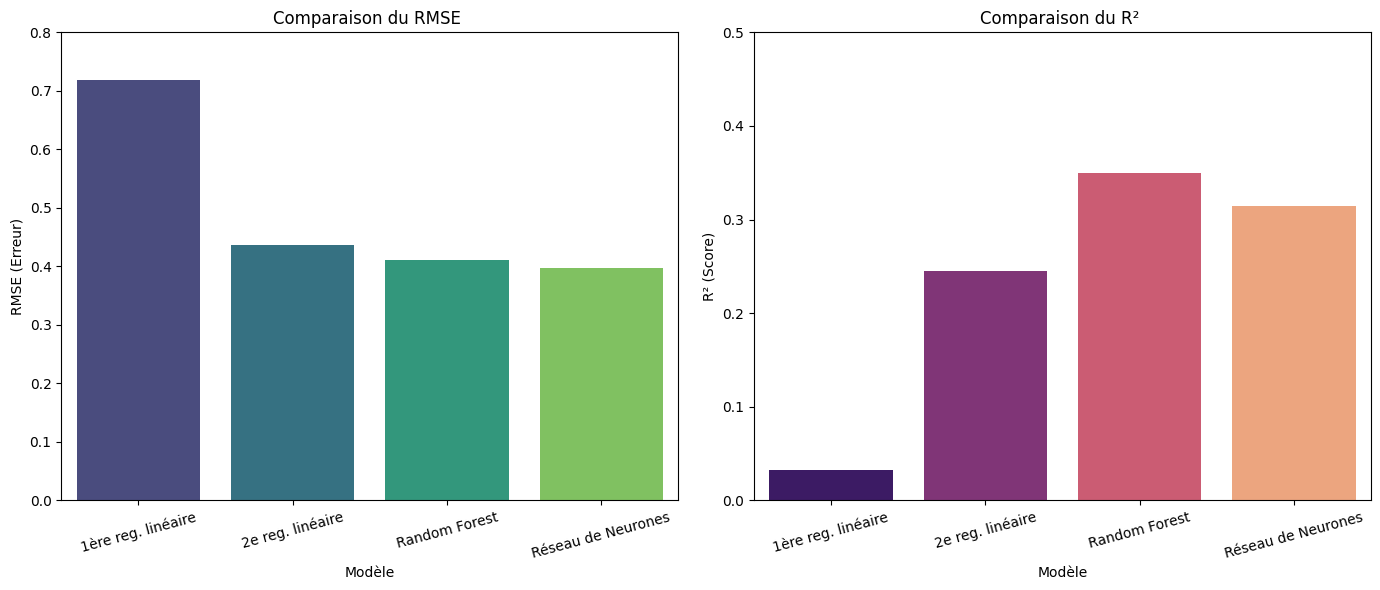

In [ ]:

#COMPARAISON FINALE ET ANALYSE DES RÉSULTATS

# Scores obtenus
resultats_resumes = {
    'Modèle': ['1ère reg. linéaire', '2e reg. linéaire', 'Random Forest', 'Réseau de Neurones'],
    'RMSE (Erreur)': [0.7183, 0.4365, 0.4107, 0.3963],  # Plus bas = mieux
    'R² (Score)':    [0.0319, 0.2454, 0.3500, 0.3146]   # Plus haut = mieux
}

df_resultats = pd.DataFrame(resultats_resumes)


# Visualisation

plt.figure(figsize=(14, 6))

#  RMSE
plt.subplot(1, 2, 1)
sns.barplot(x='Modèle', y='RMSE (Erreur)', data=df_resultats, palette='viridis')
plt.title('Comparaison du RMSE ')
plt.xticks(rotation=15)
plt.ylim(0, 0.8)

#  R2
plt.subplot(1, 2, 2)
sns.barplot(x='Modèle', y='R² (Score)', data=df_resultats, palette='magma')
plt.title('Comparaison du R² ')
plt.xticks(rotation=15)
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()